In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%config IPCompleter.use_jedi=False

#  ROC curve computation

In this notebook, simulated data are used to show the effect on ROC curve of machine learning model performance. 
Data simulate ML models with different prediction capabilities. The models are then assigning more or less appropriate score to the samples, according to an higher or lower prediction capability. 

In [3]:
def division(numerator, denominator):
    """
    Return the result of the division between numerator and denominator.
    
    Return 0 when denominator is 0.
    """
    if denominator != 0:
        return numerator / denominator
    else:      
        return 0

In [4]:
# generate synthetic data
size = 500                            # sample size
target = np.random.randint(0,2,size)   # generate target label

In [5]:
# define a series of values for the parameter delta
# delta is used to tune the "model" prediction ability
# the higher the delta, the better the model ability 

delta_values = [0,0.2,0.4,0.5,0.75]
ability = {}

# index corresponding to real positive labels
indexes_T = []
for i in range(len(target)):

    if target[i] == 1:
        indexes_T.append(i)

# index corresponding to real false labels
indexes_F = []
for i in range(len(target)):

    if target[i] == 0:
        indexes_F.append(i)

# simulate model prediction for different abilities
for delta in delta_values:        

    score = np.zeros(len(target))
    score[indexes_T] = np.random.uniform(delta,1,len(indexes_T))
    score[indexes_F] = np.random.uniform(0,1-delta,len(indexes_F))
#     a = np.logspace(-1+delta,0,len(indexes_T))
#     b = np.logspace(-1,0-delta,len(indexes_F))
#     np.random.shuffle(a)
#     np.random.shuffle(b)
#     score[indexes_T] = a
#     score[indexes_F] = b
    
    ability[delta] = {'score':score , 'iT':indexes_T, 'iF':indexes_F}
    
# for each simulation (i.e. model with different abilities)
# create a dataframe with target (real label) 
# and assigned score by the model
# NOTE:
# DataFrame objects are stored as dictionary values with "delta" as key
     
df_dict = {}

for delta in delta_values:
  
    df_dict[delta] = pd.DataFrame([target,ability[delta]['score']], index=['target','score']).T
    df_dict[delta]['target']  = df_dict[delta]['target'].apply(int)

In [6]:
df_dict[delta_values[0]].head()

,target,score
0,0,0.342400
1,0,0.464490
2,1,0.850261
3,0,0.803318
4,1,0.272315


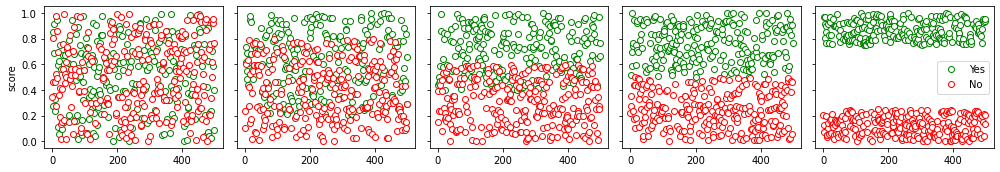

In [7]:
# plot score assigned by model qith increasing abilities
x = np.array(range(size))

plots_number = len(delta_values)
fig, ax = plt.subplots(1,plots_number,figsize=(14,2.5),sharey=True)
ax[0].set_ylabel('score')

for graph, delta in enumerate(delta_values):
    
    ax[graph].plot(x[ability[delta]['iT']], df_dict[delta]['score'][ability[delta]['iT']], 'og',mfc='w')
    ax[graph].plot(x[ability[delta]['iF']], df_dict[delta]['score'][ability[delta]['iF']], 'or',mfc='w')
    

plt.legend(['Yes', 'No'])
plt.tight_layout()

In [8]:
# compute true positive and false positive rate

# create threshold values
points_number = 30    # number of threshold values (i.e. # of points in the ROC curve)        
thresholds = sorted(np.linspace(0,1,points_number), reverse=True)  


# compute confusion matrix values for each threshold
# and (for each threshold) compute true and false positive rates
rates = {}

# make computation for each model ability
for delta in delta_values:

    rate_TP = []
    rate_FP = []
    
    # recall target and score of the model
    df = df_dict[delta]
    
    # for each threshold assigned the predicted class to each occurrence
    # and compute confusion matrix elements: 
    # true positives (TP), true negatives (TN), false positives (FP), false negatives (FN)
    for t in thresholds:    
        prediction = np.where(df['score'] >= t, 1, 0)

        cumulative_TP = 0
        cumulative_FP = 0
        cumulative_TN = 0
        cumulative_FN = 0

        for index in df.index:
           

            if (prediction[int(index)] == 1) & (df.loc[index].target == 1):
                cumulative_TP += 1

            elif (prediction[int(index)] == 1) & (df.loc[index].target == 0):
                cumulative_FP += 1

            elif (prediction[int(index)] == 0) & (df.loc[index].target == 1):
                cumulative_FN +=1

            elif (prediction[int(index)] == 0) & (df.loc[index].target == 0):
                cumulative_TN +=1
            
            # finally compute the true positive rate and the false positive rate
            tpr = division(cumulative_TP, (cumulative_TP + cumulative_FN) )
            fpr = division(cumulative_FP, (cumulative_FP + cumulative_TN) )

        rate_TP.append(tpr)
        rate_FP.append(fpr) 
        
        # for each threshold save tpr and fpr in "rates" dictionary
        rates[delta] = {'tpr':rate_TP, 
                        'fpr':rate_FP
                       }

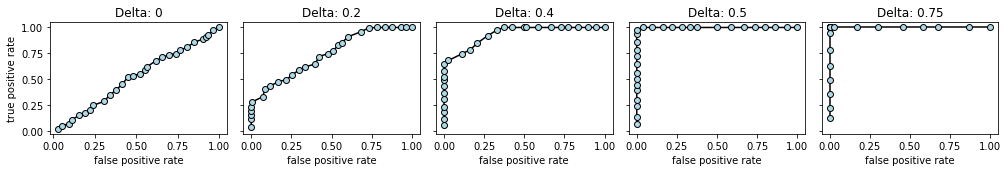

In [9]:
# plot ROC curves
plots_number = len(delta_values)
fig, ax = plt.subplots(1, plots_number, figsize=(14,2.5),sharey=True)

ax[0].set_ylabel('true positive rate')
for graph, delta in enumerate(delta_values):
    
    # collect the true and false positve rates
    rate_TP = rates[delta_values[graph]]['tpr']
    rate_FP = rates[delta_values[graph]]['fpr']
    
    ax[graph].plot(rate_FP[1:], rate_TP[1:], 'o-', 
                                             c='k', 
                                             mec='k', 
                                             mfc='lightblue')
    ax[graph].set_xlabel('false positive rate')
    ax[graph].set_title(f'Delta: {delta}')

plt.tight_layout()

# Graphical recap

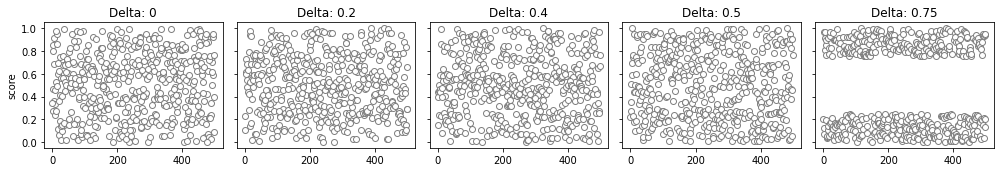

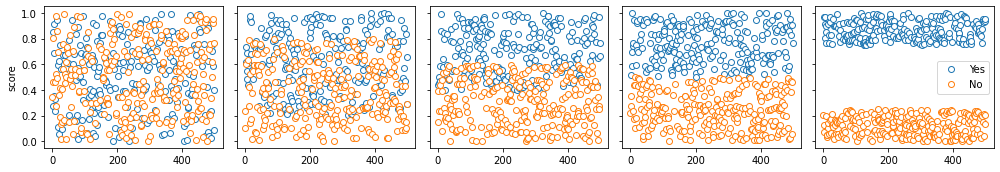

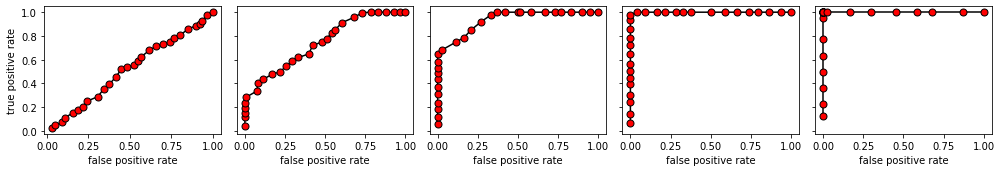

In [10]:
x = np.array(range(size))

plots_number = len(delta_values)
fig, ax = plt.subplots(1,plots_number,figsize=(14,2.5),sharey=True)
ax[0].set_ylabel('score')

for graph, delta in enumerate(delta_values):
    
    ax[graph].plot(x[ability[delta]['iT']], df_dict[delta]['score'][ability[delta]['iT']], 'o',c='gray',mfc='w')
    ax[graph].plot(x[ability[delta]['iF']], df_dict[delta]['score'][ability[delta]['iF']], 'o',c='gray',mfc='w')
    ax[graph].set_title(f'Delta: {delta}')
    
plt.tight_layout()


plots_number = len(delta_values)
fig, ax = plt.subplots(1,plots_number,figsize=(14,2.5),sharey=True)
ax[0].set_ylabel('score')

for graph, delta in enumerate(delta_values):
    
    ax[graph].plot(x[ability[delta]['iT']], df_dict[delta]['score'][ability[delta]['iT']], 'o',mfc='w')
    ax[graph].plot(x[ability[delta]['iF']], df_dict[delta]['score'][ability[delta]['iF']], 'o',mfc='w')
    

plt.legend(['Yes', 'No'])
plt.tight_layout()

plots_number = len(delta_values)
fig, ax = plt.subplots(1, plots_number, figsize=(14,2.5),sharey=True)

ax[0].set_ylabel('true positive rate')
for graph, delta in enumerate(delta_values):
    
    rate_TP = rates[delta_values[graph]]['tpr']
    rate_FP = rates[delta_values[graph]]['fpr']

    ax[graph].plot(rate_FP[1:], rate_TP[1:], 'o-', 
                                             c='k', 
                                             ms=7,
                                             mec='k', 
                                             mfc='red')
    ax[graph].set_xlabel('false positive rate')

plt.tight_layout()